In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

In [3]:
import sys

sys.path.append('../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity



In [5]:
np.random.seed(seed = 0)

def circle_class2(data, col_select = None, centers = None, r_smalls = None, r_bigs = None):
    
    centers = np.array(centers)
    cls = np.ones(len(data))
    for c, rs, rb in zip(centers, r_smalls, r_bigs):
        ans = np.sqrt(np.sum((data.values-c)**2, axis = 1))
        cls = cls&(((ans >= rs) & (ans <= rb)).astype(int))
        
    data['C'] = cls
    
    return data

In [6]:
%%time
N,D = 10**5,2
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class2', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

stats = np.array([[1, 0.75], [0, 0.75], [1, 0.75], [1, 0.75]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

CPU times: user 113 ms, sys: 33.2 ms, total: 147 ms
Wall time: 552 ms


In [7]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500673,0.501111,0.369720,0.498100,0.816729,0.817337,0.370926
std,0.288431,0.289314,0.482731,0.499999,0.841744,0.846970,1.164313
min,0.000029,0.000003,0.000000,0.000000,-2.869326,-2.787047,-4.466076
25%,0.250571,0.249306,0.000000,0.000000,0.266223,0.263298,-0.424319
50%,0.502989,0.500945,0.000000,0.000000,0.841985,0.844037,0.359827
75%,0.750030,0.752974,1.000000,1.000000,1.394533,1.396380,1.160303
max,0.999975,0.999999,1.000000,1.000000,4.041788,4.278976,5.416663


In [8]:
mpl.style.use('seaborn-paper')

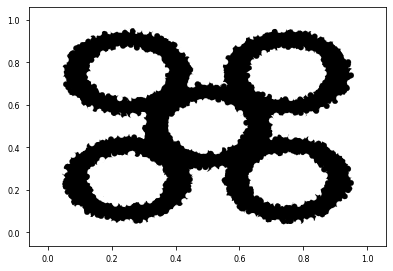

In [9]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys')


plt.show()

In [10]:
%%time
data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs={}, f2_kwargs={}, ite_name ='ITE-GDBR')

CPU times: user 11.2 s, sys: 35.5 ms, total: 11.3 s
Wall time: 39.6 s


In [11]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,1.509335,0.910739,-0.598596,0,1.003915,-0.505420
1,0.602763,0.544883,0,1,1.784335,1.040050,0.744285,0,0.484894,1.299441
2,0.423655,0.645894,1,1,0.959184,0.096788,0.862396,0,0.126470,0.832715
3,0.437587,0.891773,0,1,2.355425,1.013708,1.341717,1,0.548851,1.806574
4,0.963663,0.383442,0,0,0.365050,0.623265,0.258216,0,0.966641,0.601591


### Model performance

In [12]:
filt = (data['Treatment'] == 1) & (data['C'] == 1)
data.groupby(['Treatment', 'C'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C                                                  
0         0  0.996029  1.003422  0.997730  0.007393  0.001701
          1  0.010221  1.001653  1.002387  0.991432  0.992166
1         0  0.999283  1.005604  0.755242 -0.006321  0.244041
          1  1.007203 -0.005952  0.425805  1.013155  0.581399

### Apply clustering 

In [13]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = 100, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = 100, col_select = col_select )
data,_ = agglomerative_clustering(data.copy(), clusters = 100, col_select = col_select )

CPU times: user 1h 4min 44s, sys: 30.1 s, total: 1h 5min 14s
Wall time: 18min 16s


In [14]:
data

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,Agglomerative-Cluster
0,0.548814,0.715189,0,0,1.509335,0.910739,-0.598596,0,1.003915,-0.505420,75,50,81
1,0.602763,0.544883,0,1,1.784335,1.040050,0.744285,0,0.484894,1.299441,56,49,69
2,0.423655,0.645894,1,1,0.959184,0.096788,0.862396,0,0.126470,0.832715,64,37,86
3,0.437587,0.891773,0,1,2.355425,1.013708,1.341717,1,0.548851,1.806574,84,5,21
4,0.963663,0.383442,0,0,0.365050,0.623265,0.258216,0,0.966641,0.601591,39,40,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.396954,0.881152,1,0,-0.216128,0.290491,0.506620,0,0.977353,1.193482,83,5,21
99996,0.296909,0.377984,1,0,0.323688,0.642272,0.318583,0,0.989857,0.666169,32,67,5
99997,0.452364,0.368663,1,1,1.996809,-0.329885,2.326694,0,0.476313,1.520497,34,14,68
99998,0.305073,0.214624,0,0,0.447051,1.543869,1.096818,0,0.988014,0.540963,23,43,38


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [15]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name, hom_name = 'Box-Hom')

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name, hom_name = 'Kmeans-Hom')

agglo = ATTC(data.copy(), cluster_name = 'Agglomerative-Cluster', ATT_CLUST_name='Agglo-ATT',
           points_name='Agglo-points', weight_names='Agglo-Weights',ITE_name = ite_name, hom_name = 'Agglo-Hom')

In [16]:
kmeans

,Kmeans-Cluster,Kmeans-ATT,Kmeans-points,Kmeans-Hom,Kmeans-Weights
0,0,0.093408,473.0,0.892178,0.009496
1,1,0.617661,475.0,0.589474,0.009536
2,2,0.425868,527.0,0.573055,0.010580
3,3,0.438954,537.0,0.575419,0.010781
4,4,0.035436,510.0,0.970588,0.010239
...,...,...,...,...,...
95,95,-0.075003,439.0,1.000000,0.008813
96,96,0.436849,471.0,0.520170,0.009456
97,97,0.828631,463.0,0.803456,0.009295
98,98,0.539833,453.0,0.523179,0.009095


In [17]:
box

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.041837,493.0,1.000000,0.009898
1,1,0.266425,481.0,0.758836,0.009657
2,2,0.451344,468.0,0.506410,0.009396
3,3,0.233487,509.0,0.752456,0.010219
4,4,0.071202,497.0,1.000000,0.009978
...,...,...,...,...,...
95,95,-0.018175,512.0,1.000000,0.010279
96,96,0.221598,533.0,0.774859,0.010701
97,97,0.396937,492.0,0.504065,0.009878
98,98,0.313251,518.0,0.785714,0.010400


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


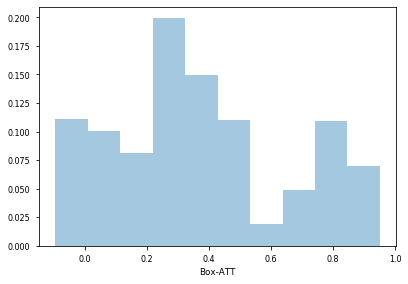

In [18]:
kde = False
sns.distplot(box['Box-ATT'], hist_kws={'weights':box['Box-Weights'].values},bins = 10, kde = kde)
plt.show()

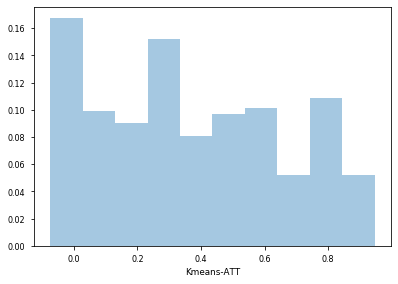

In [19]:
sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},bins = 10, kde = kde)
plt.show()

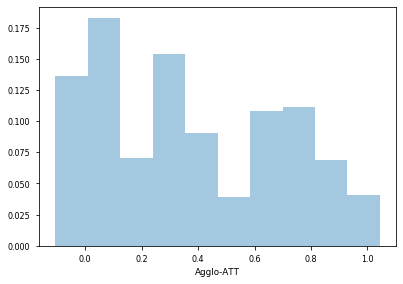

In [20]:
sns.distplot(agglo['Agglo-ATT'], hist_kws={'weights':agglo['Agglo-Weights'].values},bins = 10, kde = kde )
plt.show()

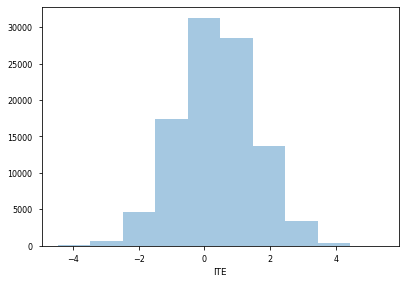

In [21]:
sns.distplot(data['ITE'], bins = 10, kde = kde)
plt.show()

In [22]:
agglo.describe()

,Agglomerative-Cluster,Agglo-ATT,Agglo-points,Agglo-Hom,Agglo-Weights
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.376742,498.100000,0.796856,0.010000
std,29.011492,0.325686,124.238488,0.160754,0.002494
min,0.000000,-0.106000,281.000000,0.500888,0.005641
25%,24.750000,0.063505,408.000000,0.649413,0.008191
50%,49.500000,0.337768,477.000000,0.810308,0.009576
75%,74.250000,0.661467,585.250000,0.955638,0.011750
max,99.000000,1.044370,813.000000,1.000000,0.016322


In [23]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.373430,498.100000,0.769146,0.010000
std,29.011492,0.287565,24.464156,0.149203,0.000491
min,0.000000,-0.095400,432.000000,0.500000,0.008673
25%,24.750000,0.178311,484.000000,0.681815,0.009717
50%,49.500000,0.327843,500.000000,0.772215,0.010038
75%,74.250000,0.534006,517.000000,0.874894,0.010379
max,99.000000,0.950573,556.000000,1.000000,0.011162


In [24]:
kmeans.describe()

,Kmeans-Cluster,Kmeans-ATT,Kmeans-points,Kmeans-Hom,Kmeans-Weights
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.369055,498.100000,0.773695,0.010000
std,29.011492,0.295296,38.320156,0.163155,0.000769
min,0.000000,-0.075003,383.000000,0.510067,0.007689
25%,24.750000,0.093363,473.000000,0.626788,0.009496
50%,49.500000,0.325674,502.500000,0.753109,0.010088
75%,74.250000,0.601051,520.000000,0.948057,0.010440
max,99.000000,0.947243,596.000000,1.000000,0.011965


### Calculate ATT per Cluster not known Model Calculated CF

In [25]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name, hom_name = 'Box-Hom')

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name, hom_name = 'Kmeans-Hom')

agglo2 = ATTC(data.copy(), cluster_name = 'Agglomerative-Cluster', ATT_CLUST_name='Agglo-ATT',
           points_name='Agglo-points', weight_names='Agglo-Weights',ITE_name = ite_name, hom_name = 'Agglo-Hom')

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


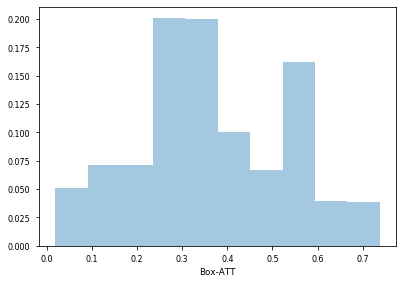

In [26]:
kde = False
bins = 10
sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde, )
plt.show()

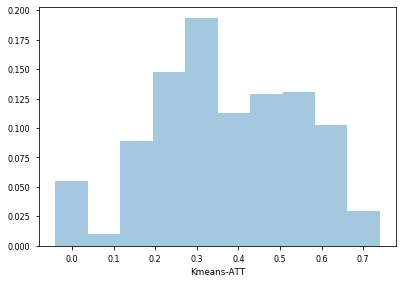

In [27]:
sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},bins = bins, kde = kde)
plt.show()

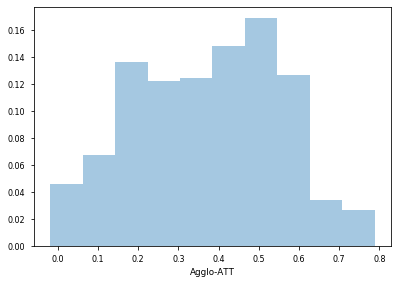

In [28]:
sns.distplot(agglo2['Agglo-ATT'], hist_kws={'weights':agglo2['Agglo-Weights'].values}, bins = bins,kde = kde )
plt.show()

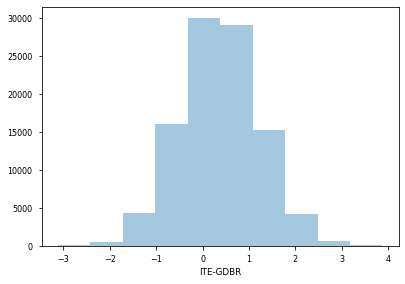

In [29]:
sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde)
plt.show()

### Weighted Kmeans 2-Clustering

In [30]:
%%time
all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']
weights = ['Box-Weights', 'Kmeans-Weights', 'Agglo-Weights', 'Box-Weights', 'Kmeans-Weights', 'Agglo-Weights']

for dd, name, name2,w in zip(all_data, names, names2,weights):
    kmeans_clustering(dd, clusters = 2, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 203 ms, sys: 11.3 ms, total: 215 ms
Wall time: 356 ms


In [31]:
box['Box-Cl2'].sum()

27

In [32]:
box.head()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.041837,493.0,1.000000,0.009898,0
1,1,0.266425,481.0,0.758836,0.009657,0
2,2,0.451344,468.0,0.506410,0.009396,0
3,3,0.233487,509.0,0.752456,0.010219,0
4,4,0.071202,497.0,1.000000,0.009978,0


In [33]:
data2 = data.copy()

In [34]:
data2.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,Agglomerative-Cluster
0,0.548814,0.715189,0,0,1.509335,0.910739,-0.598596,0,1.003915,-0.505420,75,50,81
1,0.602763,0.544883,0,1,1.784335,1.040050,0.744285,0,0.484894,1.299441,56,49,69
2,0.423655,0.645894,1,1,0.959184,0.096788,0.862396,0,0.126470,0.832715,64,37,86
3,0.437587,0.891773,0,1,2.355425,1.013708,1.341717,1,0.548851,1.806574,84,5,21
4,0.963663,0.383442,0,0,0.365050,0.623265,0.258216,0,0.966641,0.601591,39,40,98


### 2 Clustering in the ITEs

In [35]:
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CGDBR',col_select = ['ITE-GDBR'] )

In [36]:
data2,_ = box_clustering(data2,clusters = 10**4, cluster_name = 'C2-Avg', col_select = col_select)

In [37]:
data2.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,Agglomerative-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg
0,0.548814,0.715189,0,0,1.509335,0.910739,-0.598596,0,1.003915,-0.505420,75,50,81,0,0,7154
1,0.602763,0.544883,0,1,1.784335,1.040050,0.744285,0,0.484894,1.299441,56,49,69,1,1,5460
2,0.423655,0.645894,1,1,0.959184,0.096788,0.862396,0,0.126470,0.832715,64,37,86,1,1,6442
3,0.437587,0.891773,0,1,2.355425,1.013708,1.341717,1,0.548851,1.806574,84,5,21,1,1,8943
4,0.963663,0.383442,0,0,0.365050,0.623265,0.258216,0,0.966641,0.601591,39,40,98,0,1,3896


In [38]:
merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2',
                'Agglo2-Cl2','ITE-CTrue', 'ITE-CGDBR']

avg_c = data2.groupby('C2-Avg')[class_names1].mean().reset_index()

In [40]:
data2 = data2.merge(avg_c, on = 'C2-Avg', how = 'left', suffixes=("","y"))

In [41]:
data2.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,...,Kmeans2-Cl2,Agglo2-Cl2,Box-Cl2y,Kmeans-Cl2y,Agglo-Cl2y,Box2-Cl2y,Kmeans2-Cl2y,Agglo2-Cl2y,ITE-CTruey,ITE-CGDBRy
0,0.548814,0.715189,0,0,1.509335,0.910739,-0.598596,0,1.003915,-0.505420,...,1,1,0.0,1.0,1.000000,0.0,1.0,1.000000,0.200000,0.300000
1,0.602763,0.544883,0,1,1.784335,1.040050,0.744285,0,0.484894,1.299441,...,1,0,1.0,0.0,0.333333,1.0,1.0,0.333333,0.333333,0.333333
2,0.423655,0.645894,1,1,0.959184,0.096788,0.862396,0,0.126470,0.832715,...,1,1,1.0,1.0,1.000000,1.0,1.0,1.000000,0.875000,0.750000
3,0.437587,0.891773,0,1,2.355425,1.013708,1.341717,1,0.548851,1.806574,...,0,1,0.0,0.0,0.000000,0.0,0.0,1.000000,0.300000,0.600000
4,0.963663,0.383442,0,0,0.365050,0.623265,0.258216,0,0.966641,0.601591,...,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.416667


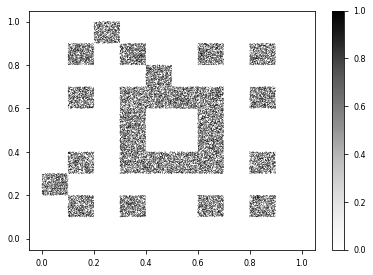

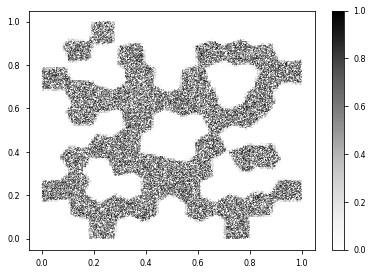

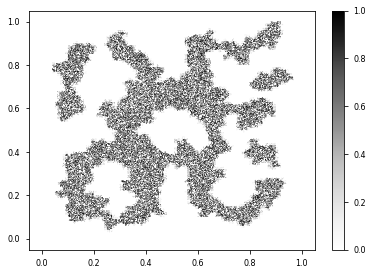

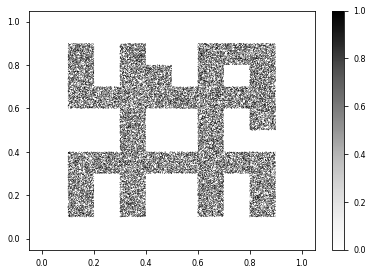

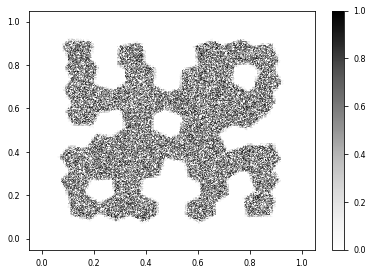

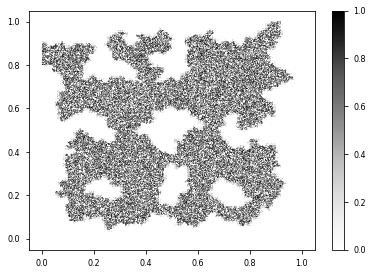

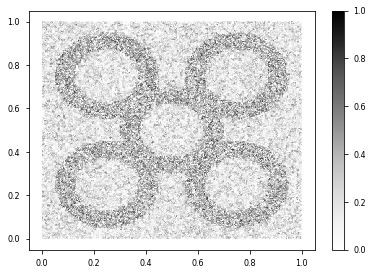

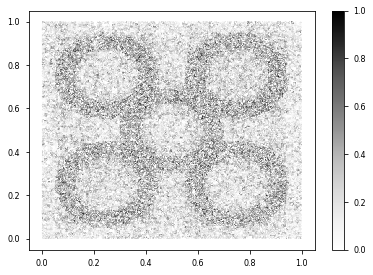

In [47]:
class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = [name+'y' for name in class_names1]
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()

    sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 0.1)
    fig.colorbar(sc)

    plt.show()

### homogeneity experiment

In [43]:
clusters = [4, 16, 25, 100]
clustering_algo = ['box_clustering', 'kmeans_clustering', 'agglomerative_clustering']

In [44]:
result = get_homogeneity(data.copy(),clusters = clusters, clustering_algo = clustering_algo, col_select = col_select)

Running:box_clustering
Number of Clusters:4 algobox_clustering
Number of Clusters:16 algobox_clustering
Number of Clusters:25 algobox_clustering
Number of Clusters:100 algobox_clustering
Running:kmeans_clustering
Number of Clusters:4 algokmeans_clustering
Number of Clusters:16 algokmeans_clustering
Number of Clusters:25 algokmeans_clustering
Number of Clusters:100 algokmeans_clustering
Running:agglomerative_clustering
Number of Clusters:4 algoagglomerative_clustering
Number of Clusters:16 algoagglomerative_clustering
Number of Clusters:25 algoagglomerative_clustering
Number of Clusters:100 algoagglomerative_clustering


In [45]:
pd.DataFrame(result)

,clusters,box_clustering,kmeans_clustering,agglomerative_clustering
0,4,0.629171,0.629171,0.629171
1,16,0.648002,0.643284,0.644088
2,25,0.685525,0.672676,0.665609
3,100,0.769966,0.773640,0.790424
